In [76]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import math
%matplotlib inline

In [77]:
torch.manual_seed(42);

In [78]:
words = open('names.txt', 'r').read().splitlines()

In [79]:
chars = ['.'] + sorted(list(set(''.join(words))))
encode = lambda c: chars.index(c)
decode = lambda i: chars[i]

In [80]:
block_size = 3
vocab_size = len(chars)

In [81]:
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for c in w + '.':
            ix = encode(c)
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [82]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(decode(x_i.item()) for x_i in x), '----->', decode(y.item()))


... -----> y
..y -----> u
.yu -----> h
yuh -----> e
uhe -----> n
hen -----> g
eng -----> .
... -----> d
..d -----> i
.di -----> o
dio -----> n
ion -----> d
ond -----> r
ndr -----> e
dre -----> .
... -----> x
..x -----> a
.xa -----> v
xav -----> i
avi -----> e


In [123]:
class Embedding:
    def __init__(self, embedding_num, embedding_dim) -> None:
        self.embeddings = torch.randn((embedding_num, embedding_dim))

    def __call__(self, x):
        self.out = self.embeddings[x]
        return self.out.view(x.shape[0], -1)
    
    def parameters(self):
        return [self.embeddings]
    
class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / (fan_in)**0.5
        self.bias = torch.zeros((fan_out)) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters for batch norm
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers trained with a running momentum update
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        self.out = (x - xmean) / (xvar + self.eps).sqrt()
        self.out = self.out * self.gamma + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = self.running_mean * (1 - self.momentum) + xmean * self.momentum
                self.running_var = self.running_var * (1 - self.momentum) + xvar * self.momentum
        
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []
    
class Sequential:
    def __init__(self, layers) -> None:
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

def initialize_model(n_layers = 6, tanh = True, bn = False, bnOutput = False, output_scale = 0.1, hidden_gain = 5/3):
    layers = [Embedding(vocab_size, n_embd), Flatten()]

    for i in range(n_layers):
        if i == 0:
            layers.append(Linear(n_embd * block_size, n_hidden, bias=not bn))
        elif i == n_layers - 1:
            layers.append(Linear(n_hidden, vocab_size, bias=not bnOutput))
        else:
            layers.append(Linear(n_hidden, n_hidden, bias=not bn))

        if bn and i < n_layers - 1:
            layers.append(BatchNorm1d(n_hidden))
        if tanh and i < n_layers - 1:
            layers.append(Tanh())

    if bnOutput:
        layers.append(BatchNorm1d(vocab_size))

    with torch.no_grad():
        # last layer: make less confident
        if bnOutput:
            layers[-1].gamma *= output_scale
        else:
            layers[-1].weight *= output_scale
        # all other layers: apply gain
        for layer in layers[:-1]:
            if isinstance(layer, Linear):
                layer.weight *= hidden_gain

    model = Sequential(layers)
    parameters = model.parameters()
    print(sum(p.nelement() for p in parameters)) # number of parameters in total
    for p in parameters:
        p.requires_grad = True

    return model


In [158]:
model = initialize_model(n_layers=2, bn=True, hidden_gain=1)

12097


In [126]:
def train(model, breakpoint = math.inf, lr=0.1):
  # same optimization as last time
  max_steps = 200000
  batch_size = 32
  lossi = []

  for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in model.parameters():
      p.grad = None
      
    loss.backward()
    
    # update
    learning_rate = lr if i < 150000 else lr/10 # step learning rate decay
    for p in model.parameters():
      p.data += -learning_rate * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())

    if breakpoint == i:
      break
  return lossi

In [164]:
lossi = train(model)

      0/ 200000: 2.2499
  10000/ 200000: 2.0491
  20000/ 200000: 2.3003
  30000/ 200000: 2.0917
  40000/ 200000: 1.9374
  50000/ 200000: 1.9730
  60000/ 200000: 2.1145
  70000/ 200000: 2.1131
  80000/ 200000: 2.2099
  90000/ 200000: 2.1483
 100000/ 200000: 2.0874
 110000/ 200000: 2.3142
 120000/ 200000: 2.3746
 130000/ 200000: 1.9890
 140000/ 200000: 2.4010


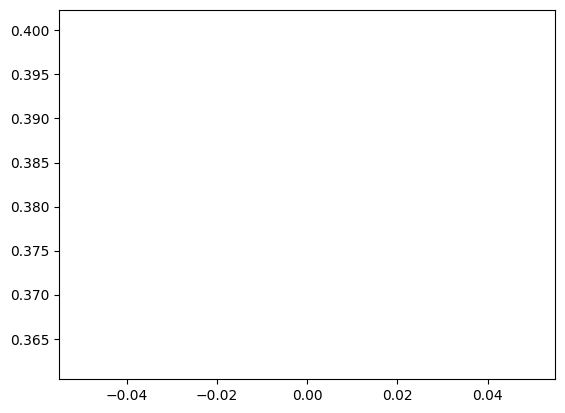

In [162]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [156]:
def disable_training(model):
  for layer in model.layers:
    layer.training = False


In [150]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(model,split):
  disable_training(model)
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xval, Yval),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss(model,'train')
split_loss(model,'val')

train nan
val nan


In [144]:
for _ in range(20):
    disable_training(model)
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(decode(i) for i in out)) # decode and print the generated word

RuntimeError: probability tensor contains either `inf`, `nan` or element < 0